In [1]:
import os
import sys
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP
from Bio.SeqUtils import seq3, seq1
from collections import Counter
import scipy.stats as scistats
from matplotlib import cm

import difflib
import Levenshtein

sys.path.append('../common')
import data_io_utils
import paths
import constants
import utils
import plot_style_utils

sys.path.append('../A008_analyze_chip_1/')
import A008_common

%reload_ext autoreload
%autoreload 2

In [2]:
GFP_LIB_REGION = [int(29), int(110)] # [inclusive, exclusive] - see A051a mlpe-gfp-pilot
BLAC_LIB_REGION = [132, 213] # [inclusive, exclusive] - see A051a mlpe-gfp-pilot

In [3]:
print(constants.BETA_LAC_AA_SEQ) ## WT avGFP aa seq

MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW


In [4]:
WT_REGION = constants.BETA_LAC_AA_SEQ[BLAC_LIB_REGION[0]:BLAC_LIB_REGION[1]]
WT_REGION

'ANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADK'

In [5]:
# confirm loading (won't use this now)
# Generated in mlpe-gfp-pilot repository
lfe_data_file = os.path.join(data_io_utils.S3_DATA_ROOT, 'chip_1', 
        'A052e_BLAC_log_fold_enrichment.csv')

data_io_utils.sync_s3_path_to_local(lfe_data_file, is_single_file=True)

df = pd.read_csv(lfe_data_file)

q = df['id'].apply(lambda s: pd.Series(A008_common.split_seq_id_into_features(s)))
df = df.merge(q, left_index=True, right_index=True)

RELEVANT_COLS = ['lfe_250', 'lfe_1000', 'lfe_2500', 'seq', 'model', 'ntrain', 'rep', 'special_case']

df_blac = df[RELEVANT_COLS]

print(df_blac.shape)
display(df_blac.head())

(9679, 8)


,lfe_250,lfe_1000,lfe_2500,seq,model,ntrain,rep,special_case
0,-1.003346,-2.423684,-2.469612,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Random_Init_1,96,3,
1,-1.207588,-2.195691,-2.400481,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,OneHot,24,2,
2,-1.449553,-1.769109,-2.618223,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,OneHot,96,0,
3,-1.268493,-2.465868,-2.812826,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,OneHot,96,3,
4,-1.417045,-1.590053,-2.227124,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Random_Init_1,96,3,


In [6]:
df_blac[df_blac['seq'] == constants.BETA_LAC_AA_SEQ]

,lfe_250,lfe_1000,lfe_2500,seq,model,ntrain,rep,special_case
3883,0.48961,-0.077452,-0.474558,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,0,


In [7]:
df_blac['qfunc'] = df_blac['lfe_1000']
df_blac['normalized_qfunc'] = df_blac['lfe_1000']
WT_FUNCTION = df_blac[df_blac['seq'] == constants.BETA_LAC_AA_SEQ]['qfunc'].values[0]
df_blac

/media/sandias42/ExDrive/Software/Python/Anaconda/envs/shared_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/media/sandias42/ExDrive/Software/Python/Anaconda/envs/shared_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,lfe_250,lfe_1000,lfe_2500,seq,model,ntrain,rep,special_case,qfunc,normalized_qfunc
0,-1.003346,-2.423684,-2.469612,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Random_Init_1,96,3,,-2.423684,-2.423684
1,-1.207588,-2.195691,-2.400481,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,OneHot,24,2,,-2.195691,-2.195691
2,-1.449553,-1.769109,-2.618223,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,OneHot,96,0,,-1.769109,-1.769109
3,-1.268493,-2.465868,-2.812826,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,OneHot,96,3,,-2.465868,-2.465868
4,-1.417045,-1.590053,-2.227124,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Random_Init_1,96,3,,-1.590053,-1.590053
5,-1.358450,-1.833374,-2.578272,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,OneHot,24,2,,-1.833374,-1.833374
6,-1.457526,-2.120399,-2.422076,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,OneHot,96,0,,-2.120399,-2.120399
7,-1.578395,-2.099076,-2.542944,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,OneHot,24,3,,-2.099076,-2.099076
8,-1.239987,-2.026063,-2.632530,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,OneHot,96,0,LargeMut,-2.026063,-2.026063
9,-1.154330,-1.885865,-2.709944,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,OneHot,24,1,,-1.885865,-1.885865


In [8]:
WT_FUNCTION

-0.07745167172002132

In [9]:
df_blac.model.value_counts()

ET_Random_Init_1    3254
ET_Global_Init_1    3224
OneHot              3201
Name: model, dtype: int64

In [10]:
df_blac = df_blac[(df_blac['model'].values == "ET_Global_Init_1")]
df_blac

,lfe_250,lfe_1000,lfe_2500,seq,model,ntrain,rep,special_case,qfunc,normalized_qfunc
19,-1.156341,-2.203767,-2.471544,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,0,LargeMut,-2.203767,-2.203767
21,-1.363510,-2.115004,-2.106211,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.115004,-2.115004
40,-1.192398,-2.295894,-2.196974,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,0,LargeMut,-2.295894,-2.295894
42,-1.256824,-1.364502,-2.451823,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,1,,-1.364502,-1.364502
43,-1.560870,-2.219854,-2.566812,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.219854,-2.219854
52,-1.278590,-2.167248,-2.690297,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.167248,-2.167248
54,-1.480060,-1.896006,-2.215033,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-1.896006,-1.896006
57,-1.246002,-1.811335,-2.158294,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,0,LargeMut,-1.811335,-1.811335
61,0.972426,0.866153,-0.996826,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,0.866153,0.866153
62,-1.529423,-2.671468,-2.416366,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,0,,-2.671468,-2.671468


In [11]:
df_blac['region'] = df_blac['seq'].map(lambda s: s[BLAC_LIB_REGION[0]: BLAC_LIB_REGION[1]])
df_blac

/media/sandias42/ExDrive/Software/Python/Anaconda/envs/shared_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,lfe_250,lfe_1000,lfe_2500,seq,model,ntrain,rep,special_case,qfunc,normalized_qfunc,region
19,-1.156341,-2.203767,-2.471544,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,0,LargeMut,-2.203767,-2.203767,NNLLLTTIGFPLELTAFLHNMGDHVTRLTRWEPCLNEAMPNDCRST...
21,-1.363510,-2.115004,-2.106211,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.115004,-2.115004,NNLLLTFIGGPVGLTVFIHNMGDHVTRLGRWEPELNEAIPNDERDT...
40,-1.192398,-2.295894,-2.196974,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,0,LargeMut,-2.295894,-2.295894,TNLLLTTIGGARELTAFLHNMGDHVTRLDRWEPELNEQIPKGERDT...
42,-1.256824,-1.364502,-2.451823,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,1,,-1.364502,-1.364502,TNLLLTMIGGPKELTAFLMNMGDLVTRLDRWEPELHEAIPNDERST...
43,-1.560870,-2.219854,-2.566812,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.219854,-2.219854,TNLLLTAIGGPCELAAFLHNMGDHVSRLFQWEPELNEAIPNDERDT...
52,-1.278590,-2.167248,-2.690297,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.167248,-2.167248,RNLLLTTMGGPQELTAFLHNMGDHPTRLDRWECELNEAIPNDERDT...
54,-1.480060,-1.896006,-2.215033,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-1.896006,-1.896006,RNLLLTFIGGPDELTAFLHNMGDHVTRLDRWEDELNEAIPNDERDT...
57,-1.246002,-1.811335,-2.158294,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,0,LargeMut,-1.811335,-1.811335,RNLWLTFIGGPNELSAFLHNMGDHVTRLDRWEPELNEAIPNDERDT...
61,0.972426,0.866153,-0.996826,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,0.866153,0.866153,SNLILTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDT...
62,-1.529423,-2.671468,-2.416366,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,0,,-2.671468,-2.671468,SNLLITTIGGPHELTAFVHNMGDHVTRLDRWEPELNEAIPNDERDT...


In [12]:
df_blac.special_case.value_counts()

            2955
LargeMut     269
Name: special_case, dtype: int64

In [13]:
# get rid of the small trust region
df_blac = df_blac[df_blac.special_case != "LargeMut"]
df_blac

,lfe_250,lfe_1000,lfe_2500,seq,model,ntrain,rep,special_case,qfunc,normalized_qfunc,region
21,-1.363510,-2.115004,-2.106211,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.115004,-2.115004,NNLLLTFIGGPVGLTVFIHNMGDHVTRLGRWEPELNEAIPNDERDT...
42,-1.256824,-1.364502,-2.451823,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,1,,-1.364502,-1.364502,TNLLLTMIGGPKELTAFLMNMGDLVTRLDRWEPELHEAIPNDERST...
43,-1.560870,-2.219854,-2.566812,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.219854,-2.219854,TNLLLTAIGGPCELAAFLHNMGDHVSRLFQWEPELNEAIPNDERDT...
52,-1.278590,-2.167248,-2.690297,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.167248,-2.167248,RNLLLTTMGGPQELTAFLHNMGDHPTRLDRWECELNEAIPNDERDT...
54,-1.480060,-1.896006,-2.215033,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-1.896006,-1.896006,RNLLLTFIGGPDELTAFLHNMGDHVTRLDRWEDELNEAIPNDERDT...
61,0.972426,0.866153,-0.996826,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,0.866153,0.866153,SNLILTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDT...
62,-1.529423,-2.671468,-2.416366,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,0,,-2.671468,-2.671468,SNLLITTIGGPHELTAFVHNMGDHVTRLDRWEPELNEAIPNDERDT...
65,-1.413604,-1.977831,-2.673369,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-1.977831,-1.977831,SNLLLTNIGGPKELTMFLHNMGDSVWRLDQWEPELNEAIPNDERDT...
66,-1.265810,-1.993909,-2.345103,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,2,,-1.993909,-1.993909,SNLLLTTIGGPKNLTAFLHNMGDHVTRLDRWEPKLNEAIPNDERDT...
67,-1.353576,-2.117295,-2.640344,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,1,,-2.117295,-2.117295,SNLLLTTIGGPKESTAFLHNMGDPVHRLDRWEPELTEAIPNDAFDT...


In [14]:
blac_struct = pd.read_csv('blac_structure_info.csv',index_col=0).set_index('dssp_index', drop=True)
blac_struct

,aa,ss,rel_ASA,ASA,coord,d_from_active
dssp_index,,,,,,
1,H,-,0.461957,85.0,[3.076 1.906 8.748],29.429510
2,P,H,0.558824,76.0,[6.665 1.888 7.407],30.205709
3,E,H,0.520619,101.0,[6.739 5.638 7.272],29.964584
4,T,H,0.007042,1.0,[ 6.61 5.515 11.036],26.237284
5,L,H,0.280488,46.0,[ 9.726 3.395 10.977],26.344999
6,V,H,0.640845,91.0,[11.311 6.072 8.894],28.293453
7,K,H,0.156098,32.0,[10.697 8.501 11.764],25.445408
8,V,H,0.000000,0.0,[11.927 6.064 14.356],22.913300
9,K,H,0.521951,107.0,[15.168 5.591 12.48 ],25.344118


In [15]:
WT_REGION

'ANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADK'

In [16]:
# Starts at 110, ends at 190
start_shift = -22
end_shift = -23
print(BLAC_LIB_REGION[1])
blac_struct.loc[BLAC_LIB_REGION[0]+start_shift:BLAC_LIB_REGION[1] + end_shift, :]

213


,aa,ss,rel_ASA,ASA,coord,d_from_active
dssp_index,,,,,,
110,A,H,0.000000,0.0,[ 6.236 3.299 44.417],8.628804
111,N,H,0.146497,23.0,[ 8.664 2.224 47.099],10.973227
112,L,H,0.115854,19.0,[ 5.899 1.968 49.718],13.895819
113,L,H,0.000000,0.0,[ 3.728 -0.116 47.475],13.606889
114,L,H,0.000000,0.0,[ 6.66 -2.32 46.542],13.327358
115,T,H,0.640845,91.0,[ 7.091 -2.968 50.243],16.468018
116,T,H,0.190141,27.0,[ 3.459 -3.963 50.562],18.141924
117,I,H,0.118343,20.0,[ 3.73 -6.661 47.929],18.084209
118,G,T,0.523810,44.0,[ 7.048 -8.078 48.932],19.072718


In [17]:
# get the region. 
blac_struct = blac_struct.loc[BLAC_LIB_REGION[0]+start_shift:BLAC_LIB_REGION[1] + end_shift, :]
assert len(WT_REGION) == len(blac_struct)
blac_struct

,aa,ss,rel_ASA,ASA,coord,d_from_active
dssp_index,,,,,,
110,A,H,0.000000,0.0,[ 6.236 3.299 44.417],8.628804
111,N,H,0.146497,23.0,[ 8.664 2.224 47.099],10.973227
112,L,H,0.115854,19.0,[ 5.899 1.968 49.718],13.895819
113,L,H,0.000000,0.0,[ 3.728 -0.116 47.475],13.606889
114,L,H,0.000000,0.0,[ 6.66 -2.32 46.542],13.327358
115,T,H,0.640845,91.0,[ 7.091 -2.968 50.243],16.468018
116,T,H,0.190141,27.0,[ 3.459 -3.963 50.562],18.141924
117,I,H,0.118343,20.0,[ 3.73 -6.661 47.929],18.084209
118,G,T,0.523810,44.0,[ 7.048 -8.078 48.932],19.072718


In [18]:
len(blac_struct)

81

In [19]:
df_blac.region[df_blac.region.map(lambda s: True if s[:2] == "AN" else False)]

306     ANKLLTMIGGPQELTAFLHNMGDHATRLDCWEPSLYEAIPNDERDT...
307     ANKLLTDIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDTRDT...
309     ANKLLCTIGGPREITAFLHNMGDHVTRLDGWEPELNEAIPNEERDT...
324     ANNLLLTIGGPKELTAFLHNMGDHPTTLDRWEVEVNEAIPNDERDT...
336     ANTLLTSIGGPKELTAFLHNMGDHSTRLDRWEKELNEAIPNDERDT...
345     ANRLLTTMGGPYELTAFVHNMGDDVTRLDRWEPALNEAIPNDERDT...
346     ANRLLTRIGGPDELTAFLHNMGDHVTRLKRWEPEMNEAIPNDQRDT...
348     ANRLLLTIGGPKELTAFLHNMGDHVTRLDIWECELNQDIPNDERDT...
350     ANIILTTIGGPKELTAFLHNMGDHVTRLDRWESELNEAIPNDVRDT...
362     ANILLTNIGGPRELTAFAHNMGDHVTKLARWEPELNEAIPNDERET...
369     ANILLTTIGGPKELTTFLHNMGDHVVRLDRWEPELNEAIPNDERDT...
370     ANILLTTIGGPKELTIFLHNMGDHVTRLDRIEPVLNEAIPNDPRDT...
371     ANILLTTIGGPKELTQFLHNMGDHVNRLDRWEPELNEAMPNDERDT...
375     ANILLTTIGGPKELTAFVHNMGDHVTRLDRWEPELNEAIPNDERDT...
378     ANILLTTIGGPKELTAFLHNMGDKITRLDRWEPELNEAIPNDERDT...
379     ANILLTTIGGPKELTAFLHNMGDTVTHLDRWEPELNEAIPNDERDT...
380     ANILLTTIGGPKELTAFLHNMGDTVTRLDRWEPELNEAIPNDERDT...
381     ANILLT

In [20]:
df_blac

,lfe_250,lfe_1000,lfe_2500,seq,model,ntrain,rep,special_case,qfunc,normalized_qfunc,region
21,-1.363510,-2.115004,-2.106211,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.115004,-2.115004,NNLLLTFIGGPVGLTVFIHNMGDHVTRLGRWEPELNEAIPNDERDT...
42,-1.256824,-1.364502,-2.451823,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,1,,-1.364502,-1.364502,TNLLLTMIGGPKELTAFLMNMGDLVTRLDRWEPELHEAIPNDERST...
43,-1.560870,-2.219854,-2.566812,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.219854,-2.219854,TNLLLTAIGGPCELAAFLHNMGDHVSRLFQWEPELNEAIPNDERDT...
52,-1.278590,-2.167248,-2.690297,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.167248,-2.167248,RNLLLTTMGGPQELTAFLHNMGDHPTRLDRWECELNEAIPNDERDT...
54,-1.480060,-1.896006,-2.215033,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-1.896006,-1.896006,RNLLLTFIGGPDELTAFLHNMGDHVTRLDRWEDELNEAIPNDERDT...
61,0.972426,0.866153,-0.996826,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,0.866153,0.866153,SNLILTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDT...
62,-1.529423,-2.671468,-2.416366,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,0,,-2.671468,-2.671468,SNLLITTIGGPHELTAFVHNMGDHVTRLDRWEPELNEAIPNDERDT...
65,-1.413604,-1.977831,-2.673369,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-1.977831,-1.977831,SNLLLTNIGGPKELTMFLHNMGDSVWRLDQWEPELNEAIPNDERDT...
66,-1.265810,-1.993909,-2.345103,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,2,,-1.993909,-1.993909,SNLLLTTIGGPKNLTAFLHNMGDHVTRLDRWEPKLNEAIPNDERDT...
67,-1.353576,-2.117295,-2.640344,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,1,,-2.117295,-2.117295,SNLLLTTIGGPKESTAFLHNMGDPVHRLDRWEPELTEAIPNDAFDT...


In [21]:
num_positions = BLAC_LIB_REGION[1] - BLAC_LIB_REGION[0]
print(num_positions)

81


In [22]:
# This looks right to me. Now compute the mutation frequency per position


# for each position, make a dictionary of counts of the mutations
num_mutants = [0 for _ in range(num_positions)]
counters = [Counter() for _ in range(num_positions)]

for seq in df_blac.region:
    for position, aa in enumerate(seq):
        counters[position].update([aa])
        if WT_REGION[position] != aa:
            num_mutants[position] += 1
            
print(len(counters))
print(counters[0])

81
Counter({'A': 2894, 'S': 29, 'V': 8, 'G': 7, 'M': 5, 'T': 2, 'R': 2, 'Q': 2, 'C': 2, 'N': 1, 'D': 1, 'W': 1, 'L': 1})


In [23]:
with open("all_blac_ET_mutation_counts.pkl", 'wb') as f:
    pickle.dump(counters,f)

In [24]:
# now do a subset for just the bright= functional ones

df_bright = df_blac[df_blac['qfunc'] >= WT_FUNCTION]
num_bright_mutants = [0 for _ in range(num_positions)]
# for each position, make a dictionary of counts of the mutations
bright_counters = [Counter() for _ in range(num_positions)]

for seq in df_bright.region:
    for position, aa in enumerate(seq):
        bright_counters[position].update([aa])
        if WT_REGION[position] != aa:
            num_bright_mutants[position] += 1
print(len(bright_counters))
print(bright_counters[0])

81
Counter({'A': 302, 'S': 3})


In [25]:
df_bright

,lfe_250,lfe_1000,lfe_2500,seq,model,ntrain,rep,special_case,qfunc,normalized_qfunc,region
61,0.972426,0.866153,-0.996826,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,0.866153,0.866153,SNLILTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDT...
74,0.865278,1.374012,-1.066368,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,1.374012,1.374012,SNLLLTTIGGPKELTAFLYNMGDHVTRLDRWEPELNEAMPNDERDT...
83,0.923991,1.075832,-1.213811,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,1.075832,1.075832,SNLLLTTVGGPKELTAFLHNMGDHVTRIDRWEPELNEAIPNDERDT...
378,0.926344,1.141497,-1.182145,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,3,,1.141497,1.141497,ANILLTTIGGPKELTAFLHNMGDKITRLDRWEPELNEAIPNDERDT...
380,0.897095,1.509842,1.516078,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,1.509842,1.509842,ANILLTTIGGPKELTAFLHNMGDTVTRLDRWEPELNEAIPNDERDT...
381,0.903322,1.507083,1.032197,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,1.507083,1.507083,ANILLTTIGGPKELTAFLHNMGDHITRLDRWEPELNQAIPNDERDS...
393,0.963413,1.040076,-1.413288,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,1.040076,1.040076,ANILLTTIGGPKELAGFLHAMGDHVTRLDRWEPELNEAIPNDERDT...
394,0.962640,1.263997,-1.134769,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,3,,1.263997,1.263997,ANILLTTIGGPKEVTAFIHNMGDHVTRLDRWEPELNEAIPNDERDT...
408,0.954541,-0.024209,-1.270702,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,-0.024209,-0.024209,ANILLTTIGGPRELTIFLHNMGDHVTRLDRWEPEVNEAIPNDERDT...
411,0.953524,1.505887,-0.948183,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,1.505887,1.505887,ANILLTTIGGPAELTSFLHQMGDHVTRLDRWEPELNEAIPNDERDT...


In [26]:
with open("lfe_100_gtWT_ET_mutation_counts.pkl", 'wb') as f:
    pickle.dump(bright_counters,f)

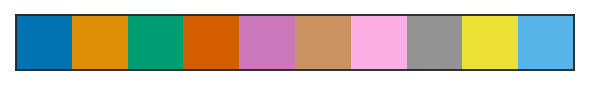

In [27]:
plot_style_utils.set_pub_plot_context()
palette = plot_style_utils.CAT_PALETTE
sns.palplot(plot_style_utils.CAT_PALETTE)

## What to analyze
1. Mutation frequency in buried vs exposed regions
2. Mutation frequency in helices, sheets, and loops
3. Pairs of Cysteine-cysteine bonds

In [28]:
# Followin https://academic.oup.com/nar/article/33/10/3193/1009111, we classify buried residues as those with
# Relative Solvent Accessibility < .2
blac_struct['buried'] = blac_struct['rel_ASA'] <= .2
blac_struct

/media/sandias42/ExDrive/Software/Python/Anaconda/envs/shared_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,aa,ss,rel_ASA,ASA,coord,d_from_active,buried
dssp_index,,,,,,,
110,A,H,0.000000,0.0,[ 6.236 3.299 44.417],8.628804,True
111,N,H,0.146497,23.0,[ 8.664 2.224 47.099],10.973227,True
112,L,H,0.115854,19.0,[ 5.899 1.968 49.718],13.895819,True
113,L,H,0.000000,0.0,[ 3.728 -0.116 47.475],13.606889,True
114,L,H,0.000000,0.0,[ 6.66 -2.32 46.542],13.327358,True
115,T,H,0.640845,91.0,[ 7.091 -2.968 50.243],16.468018,False
116,T,H,0.190141,27.0,[ 3.459 -3.963 50.562],18.141924,True
117,I,H,0.118343,20.0,[ 3.73 -6.661 47.929],18.084209,True
118,G,T,0.523810,44.0,[ 7.048 -8.078 48.932],19.072718,False


In [29]:
# First compute the random solvent vs exposed
# That's just (in expectation) the frequency of buried = True

expectation_buried = blac_struct.buried.sum() / len(blac_struct)
expectation_exposed = (len(blac_struct) - blac_struct.buried.sum()) / len(blac_struct)
print(expectation_buried)
print(expectation_exposed)

0.49382716049382713
0.5061728395061729


In [30]:
# now for all ET
num_mutants

[61,
 51,
 119,
 76,
 125,
 278,
 232,
 129,
 15,
 3,
 27,
 465,
 466,
 395,
 170,
 628,
 194,
 355,
 194,
 521,
 211,
 18,
 32,
 334,
 285,
 418,
 212,
 305,
 300,
 583,
 163,
 229,
 438,
 588,
 173,
 217,
 396,
 218,
 310,
 86,
 182,
 128,
 349,
 89,
 204,
 97,
 37,
 326,
 4,
 371,
 279,
 187,
 131,
 248,
 146,
 158,
 152,
 478,
 227,
 194,
 283,
 212,
 361,
 803,
 256,
 304,
 308,
 340,
 261,
 137,
 374,
 403,
 115,
 249,
 175,
 2,
 218,
 225,
 318,
 14,
 250]

In [31]:
len(df_blac)

2955

In [32]:
len(df_bright)

305

In [33]:
num_bright_mutants

[3,
 0,
 14,
 3,
 10,
 33,
 23,
 23,
 0,
 0,
 0,
 64,
 52,
 29,
 8,
 63,
 19,
 23,
 19,
 78,
 22,
 2,
 0,
 29,
 26,
 3,
 8,
 25,
 4,
 25,
 10,
 0,
 10,
 53,
 8,
 1,
 40,
 9,
 51,
 3,
 16,
 1,
 22,
 1,
 0,
 7,
 2,
 43,
 0,
 63,
 13,
 11,
 3,
 31,
 7,
 17,
 21,
 60,
 28,
 16,
 38,
 30,
 32,
 130,
 4,
 33,
 48,
 50,
 6,
 24,
 48,
 31,
 6,
 54,
 16,
 0,
 1,
 19,
 24,
 0,
 26]

/media/sandias42/ExDrive/Software/Python/Anaconda/envs/shared_analysis/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


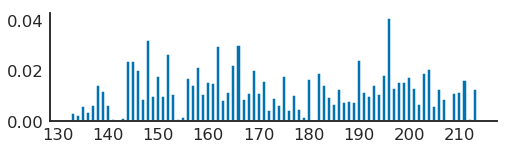

In [34]:
num_mutants = np.array(num_mutants)
fig, ax = plot_style_utils.simple_ax(figsize=(8,2))
ax.bar(np.arange(BLAC_LIB_REGION[0], BLAC_LIB_REGION[1])+1,num_mutants / np.sum(num_mutants), color=palette[0]  )
plot_style_utils.save_for_pub(fig,'./blac_ET_linear_mutation_freq.pdf')

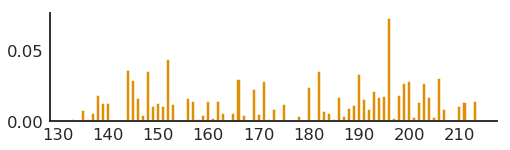

In [35]:
num_bright_mutants = np.array(num_bright_mutants)
fig, ax = plot_style_utils.simple_ax(figsize=(8,2))
ax.bar(np.arange(BLAC_LIB_REGION[0], BLAC_LIB_REGION[1])+1,num_bright_mutants / np.sum(num_bright_mutants), color=palette[1] )
plot_style_utils.save_for_pub(fig, './blac_bright_linear_mutation_freq.pdf')

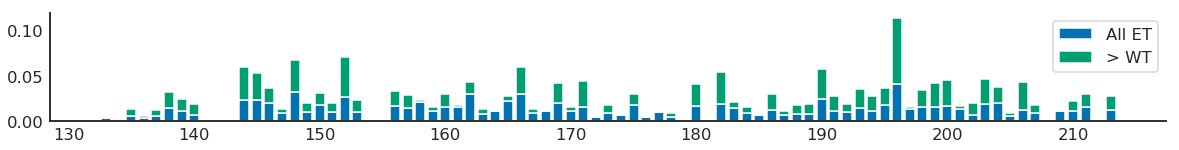

In [36]:
num_mutants = np.array(num_mutants)
fig, ax = plot_style_utils.simple_ax(figsize=(20,2))
ax.bar(np.arange(BLAC_LIB_REGION[0], BLAC_LIB_REGION[1]) + 1,num_mutants / np.sum(num_mutants), color=palette[0], label="All ET")
ax.bar(np.arange(BLAC_LIB_REGION[0], BLAC_LIB_REGION[1]) + 1,num_bright_mutants / np.sum(num_bright_mutants), color=palette[2], bottom=num_mutants / np.sum(num_mutants), label="> WT")
ax.legend()
plot_style_utils.save_for_pub(fig,'./blac_stacked_linear_mutation_freq.pdf')

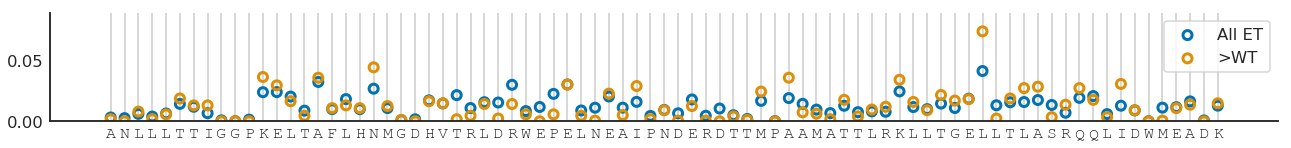

In [37]:
num_mutants = np.array(num_mutants)
max_val = np.max(num_bright_mutants / np.sum(num_bright_mutants))
fig, ax = plot_style_utils.simple_ax(figsize=(22,2))
x = np.arange(BLAC_LIB_REGION[0], BLAC_LIB_REGION[1]) + 1
#ax.bar(np.arange(GFP_LIB_REGION[0], GFP_LIB_REGION[1]) + 1,np.zeros(num_mutants.shape) + max_val, color='black', width=.1, alpha=.2)
ax.scatter(x,num_mutants / np.sum(num_mutants), 
           color=palette[0], label="All ET", marker='o', facecolors='none', linewidth=3)
ax.scatter(x,num_bright_mutants / np.sum(num_bright_mutants), 
           color=palette[1], label=">WT", marker='o', facecolors='none', linewidth=3)
ax.set_ylim(0, None)
ax.xaxis.grid(True)
ax.set_xticks(x)
ax.set_xticklabels(list(WT_REGION), fontname='Courier New')
ax.legend()
plot_style_utils.save_for_pub(fig,'./blac_scatter_mutation_freq.pdf')

In [38]:
# get the PSSM and compute the effective number of mutations per residue in this window
from proteinnet_parser import _aa_dict
print(_aa_dict)
id_dict = {int(v):k for k,v in _aa_dict.items()}
pssm = pickle.load(open("blac_1zg4_pssm.pkl", 'rb'))
pssm_seq = "".join([id_dict[aa] for aa in pssm['primary']])
pssm = np.array(pssm['evolutionary'])
print(pssm_seq)

{'A': '0', 'C': '1', 'D': '2', 'E': '3', 'F': '4', 'G': '5', 'H': '6', 'I': '7', 'K': '8', 'L': '9', 'M': '10', 'N': '11', 'P': '12', 'Q': '13', 'R': '14', 'S': '15', 'T': '16', 'V': '17', 'W': '18', 'Y': '19'}
MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRIDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPVAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW


In [39]:
print("".join(blac_struct.aa.values))

ANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPVAMATTLRKLLTGELLTLASRQQLIDWMEADK


In [40]:
np.argmax(pssm[:,BLAC_LIB_REGION[1]-9])

9

In [41]:
region_pssm = pssm[:,BLAC_LIB_REGION[0]:BLAC_LIB_REGION[1]]
print("".join([id_dict[np.argmax(column)] for column in region_pssm.T] ))

ANALAERLGGVDAMNEYAKELGLTNTRFDNPSGLLNEAAPGQGGNASTPLDLARLLAALANGEVLSPETAALLRDLMEGVV


In [42]:
print(pssm_seq[BLAC_LIB_REGION[0]:BLAC_LIB_REGION[1]])

ANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPVAMATTLRKLLTGELLTLASRQQLIDWMEADK


# Notice the maximum likelihood in the PSSM is actually very different from the WT sequence

In [43]:
region_pssm = region_pssm.T

In [44]:
np.sum(region_pssm, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [45]:
# Avoid log 0
EPSILON = .00000000000001

region_entropy = np.array([-np.sum(p*np.log(p + EPSILON)) for p in region_pssm])
region_entropy

array([1.87832464, 2.65761044, 2.65153888, 1.4189798 , 1.9870642 ,
       2.51937763, 2.6539898 , 1.94339229, 1.4440657 , 2.61055006,
       2.29005396, 2.20788885, 2.6436075 , 1.91123484, 2.38848643,
       2.31549978, 2.57136364, 1.79473856, 2.37641806, 2.4203466 ,
       1.87441566, 0.85033403, 2.02185809, 2.59018344, 2.46785678,
       2.04262776, 2.68841742, 2.23565931, 2.68185136, 2.47447698,
       2.3693885 , 2.45627524, 1.63825303, 2.18885583, 2.56249686,
       2.61325178, 2.51411187, 2.33629007, 2.68796061, 2.56361115,
       2.57303683, 2.29300123, 2.4191728 , 2.64387871, 2.48085553,
       2.63980095, 2.15761045, 1.0230437 , 1.4687446 , 2.47557367,
       1.70888282, 1.80230043, 1.87241605, 2.58543105, 2.05749076,
       2.26498302, 2.40195411, 2.32780301, 1.85712469, 2.29566039,
       2.27918872, 2.51041336, 2.46085317, 2.58831092, 2.01845898,
       2.42770788, 2.23888713, 2.6481938 , 2.53370943, 2.44218522,
       2.56089665, 2.73631956, 2.33070792, 2.59135667, 2.53606

/media/sandias42/ExDrive/Software/Python/Anaconda/envs/shared_analysis/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


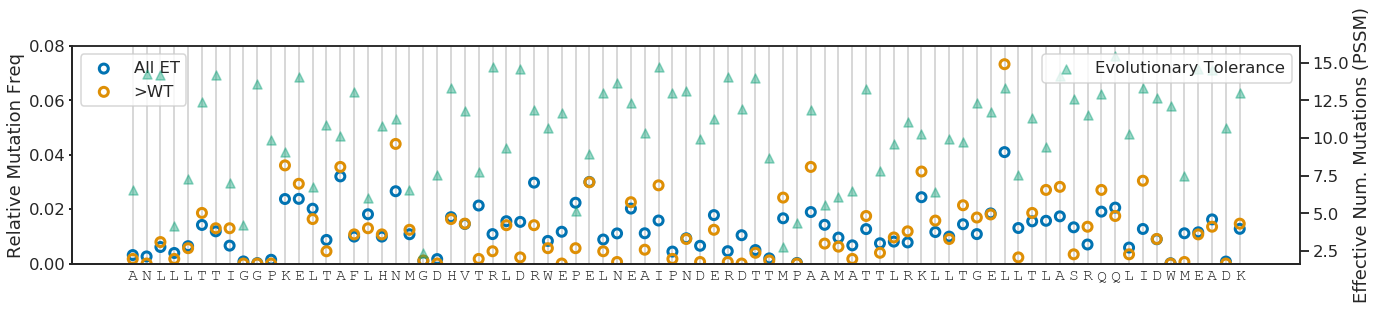

In [46]:
num_mutants = np.array(num_mutants)
max_val = np.max(num_bright_mutants / np.sum(num_bright_mutants))
fig, ax = plot_style_utils.simple_ax(figsize=(22,4))
x = np.arange(BLAC_LIB_REGION[0], BLAC_LIB_REGION[1]) + 1
#ax.bar(np.arange(GFP_LIB_REGION[0], GFP_LIB_REGION[1]) + 1,np.zeros(num_mutants.shape) + max_val, color='black', width=.1, alpha=.2)
ax.scatter(x,num_mutants / np.sum(num_mutants), 
           color=palette[0], label="All ET", marker='o', facecolors='none', linewidth=3)
ax.scatter(x,num_bright_mutants / np.sum(num_bright_mutants), 
           color=palette[1], label=">WT", marker='o', facecolors='none', linewidth=3)
ax.set_ylim(0, None)


ax.xaxis.grid(True)
ax.set_xticks(x)
ax.set_xticklabels(list(WT_REGION), fontname='Courier New')
ax.set_ylabel('Relative Mutation Freq')
ax2 = ax.twinx()
ax2.scatter(x, np.exp(region_entropy), color=palette[2], marker='^', alpha=.4, label='Evolutionary Tolerance')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylabel('Effective Num. Mutations (PSSM)')#, rotation=-90)

plot_style_utils.save_for_pub(fig,'./blac_scatter_entropy_mutation_freq.pdf')

avg effective number of mutations is 10.518601390930769


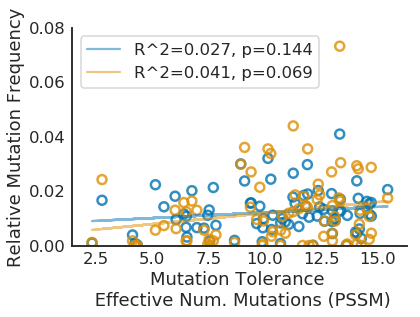

In [47]:
### fig = plt.figure(figsize=(4,4))
#ax = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)
x = np.exp(region_entropy)
print(f'avg effective number of mutations is {np.mean(x)}')
slope, intercept, r_value, p_value, std_err = scistats.linregress(x, num_mutants/ np.sum(num_mutants))
fig, ax = plot_style_utils.simple_ax(figsize=(6,4))
sns.regplot(x, num_mutants/ np.sum(num_mutants), color=palette[0],
            marker='o', ax=ax, scatter_kws={'facecolor':'none', 'linewidth':2.5, 'alpha':.8}, line_kws={'alpha':1},
           fit_reg=False)
ax.plot(x, intercept + slope*x, color=palette[0], alpha=.5, 
        label=f'R^2={np.around(r_value**2, 3)}, p={np.around(p_value, 3)}')

slope, intercept, r_value, p_value, std_err = scistats.linregress(x, num_bright_mutants/ np.sum(num_bright_mutants))
sns.regplot(x, num_bright_mutants/ np.sum(num_bright_mutants), color=palette[1],
            marker='o', ax=ax, scatter_kws={'facecolor':'none', 'linewidth':2.5, 'alpha':.8}, line_kws={'alpha':1},
           fit_reg=False)
ax.plot(x, intercept + slope*x, color=palette[1], alpha=.5, 
        label=f'R^2={np.around(r_value**2, 3)}, p={np.around(p_value, 3)}')
ax.set_ylim(0,None)
ax.set_xlabel('Mutation Tolerance \n Effective Num. Mutations (PSSM)')
ax.set_ylabel('Relative Mutation Frequency')
ax.legend()
plot_style_utils.save_for_pub(fig,'./blac_entropy_vs_mutation_freq.pdf')

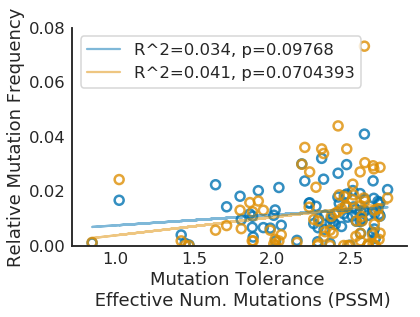

In [48]:
x = region_entropy

slope, intercept, r_value, p_value, std_err = scistats.linregress(x, num_mutants/ np.sum(num_mutants))
fig, ax = plot_style_utils.simple_ax(figsize=(6,4))
sns.regplot(x, num_mutants/ np.sum(num_mutants), color=palette[0],
            marker='o', ax=ax, scatter_kws={'facecolor':'none', 'linewidth':2.5, 'alpha':.8}, line_kws={'alpha':1},
           fit_reg=False), #facecolors='none', linewidth=
ax.plot(x, intercept + slope*x, color=palette[0], alpha=.5, 
        label=f'R^2={np.around(r_value**2, 3)}, p={np.around(p_value, 5)}')

slope, intercept, r_value, p_value, std_err = scistats.linregress(x, num_bright_mutants/ np.sum(num_bright_mutants))
sns.regplot(x, num_bright_mutants/ np.sum(num_bright_mutants), color=palette[1],
            marker='o', ax=ax, scatter_kws={'facecolor':'none', 'linewidth':2.5, 'alpha':.8}, line_kws={'alpha':1},
           fit_reg=False)#, facecolors='none', linewidth=3)
ax.plot(x, intercept + slope*x, color=palette[1], alpha=.5, 
        label=f'R^2={np.around(r_value**2, 3)}, p={np.around(p_value, 7)}')
ax.set_ylim(0,None)
ax.set_xlabel('Mutation Tolerance \n Effective Num. Mutations (PSSM)')
ax.set_ylabel('Relative Mutation Frequency')
ax.legend()

In [49]:
# Treat each buried position in the WT structure as one observation
per_residue_counts = num_mutants[blac_struct['buried']]

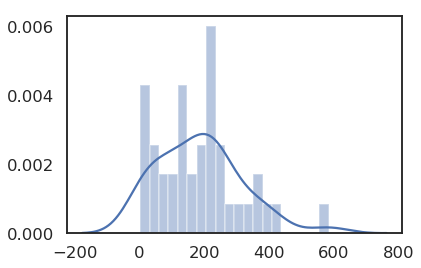

In [50]:
sns.distplot(per_residue_counts, bins=20)

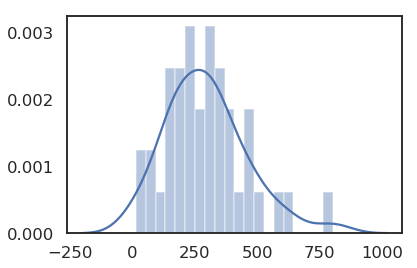

In [51]:
# Look at the exposed
per_residue_counts = num_mutants[~blac_struct['buried']]
sns.distplot(per_residue_counts, bins=20)

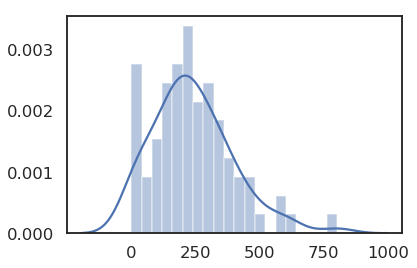

In [52]:
# and the entire histogram
per_residue_counts = num_mutants
sns.distplot(per_residue_counts, bins=20)

In [53]:
all_ET_buried_freq = np.sum(num_mutants[blac_struct['buried']]) / np.sum(num_mutants)
all_ET_exposed_freq = np.sum(num_mutants[~blac_struct['buried']]) / np.sum(num_mutants)

In [54]:
all_ET_buried_freq

0.3790466479734897

In [55]:
bright_buried_freq = np.sum(num_bright_mutants[blac_struct['buried']]) / np.sum(num_bright_mutants)
bright_exposed_freq = np.sum(num_bright_mutants[~blac_struct['buried']]) / np.sum(num_bright_mutants)
bright_buried_freq

0.2828169014084507

In [56]:
print(f"We expect {expectation_buried} of mutations to be buried, UniRep designs {all_ET_buried_freq}, and after filtering for brighter than WT we have {bright_buried_freq}")

We expect 0.49382716049382713 of mutations to be buried, UniRep designs 0.3790466479734897, and after filtering for brighter than WT we have 0.2828169014084507


In [57]:
blac_struct.ss.value_counts()

H    43
-    15
T    10
S     8
G     3
E     2
Name: ss, dtype: int64

In [58]:
blac_struct.loc[132:135,:]

,aa,ss,rel_ASA,ASA,coord,d_from_active,buried
dssp_index,,,,,,,
132,D,-,0.042945,7.0,[ 6.144 -12.488 30.949],20.413719,True
133,H,S,0.701087,129.0,[ 9.501 -14.24 31.366],21.731352,False
134,V,S,0.260563,37.0,[ 11.451 -11.184 30.22 ],19.302414,False
135,T,-,0.028169,4.0,[10.468 -8.127 32.249],15.664116,True


In [59]:
# 132 DSSP index = 157 struct index
blac_struct[blac_struct.ss == '-']

,aa,ss,rel_ASA,ASA,coord,d_from_active,buried
dssp_index,,,,,,,
132,D,-,0.042945,7.0,[ 6.144 -12.488 30.949],20.413719,True
135,T,-,0.028169,4.0,[10.468 -8.127 32.249],15.664116,True
136,R,-,0.306452,76.0,[12.321 -7.908 35.564],15.015744,False
137,L,-,0.018293,3.0,[12.425 -5.571 38.489],12.756805,True
138,D,-,0.337423,55.0,[15.506 -5.843 40.674],14.460167,False
139,R,-,0.125000,31.0,[15.954 -2.562 42.574],12.663509,True
140,W,-,0.396476,90.0,[13.962 0.108 44.335],10.849938,False
146,E,-,0.376289,73.0,[20.654 3.849 36.655],11.726409,False
147,A,-,0.113208,12.0,[20.51 2.493 33.096],12.639932,True


In [60]:
# Manually classified the residues which were none- these are all loops
parse = {
    'H':'H',
    'G':'H',
    'I':'H',
    'B':'B',
    'E':'B',
    'T':'L',
    'S':'L',
    '-':'L',
        
        }
blac_struct['simple_ss'] = blac_struct.ss.map(lambda s: parse[s])
blac_struct

/media/sandias42/ExDrive/Software/Python/Anaconda/envs/shared_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,aa,ss,rel_ASA,ASA,coord,d_from_active,buried,simple_ss
dssp_index,,,,,,,,
110,A,H,0.000000,0.0,[ 6.236 3.299 44.417],8.628804,True,H
111,N,H,0.146497,23.0,[ 8.664 2.224 47.099],10.973227,True,H
112,L,H,0.115854,19.0,[ 5.899 1.968 49.718],13.895819,True,H
113,L,H,0.000000,0.0,[ 3.728 -0.116 47.475],13.606889,True,H
114,L,H,0.000000,0.0,[ 6.66 -2.32 46.542],13.327358,True,H
115,T,H,0.640845,91.0,[ 7.091 -2.968 50.243],16.468018,False,H
116,T,H,0.190141,27.0,[ 3.459 -3.963 50.562],18.141924,True,H
117,I,H,0.118343,20.0,[ 3.73 -6.661 47.929],18.084209,True,H
118,G,T,0.523810,44.0,[ 7.048 -8.078 48.932],19.072718,False,L


In [61]:
# Now do secondary structure
expectation = blac_struct.simple_ss.value_counts() / len(blac_struct)
expectation

H    0.567901
L    0.407407
B    0.024691
Name: simple_ss, dtype: float64

In [62]:
# all_mutants
all_mutants = {k: np.sum(num_mutants[blac_struct.simple_ss == k]) for k in ['B', 'L', 'H']}
all_mutants

{'B': 134, 'L': 8352, 'H': 11129}

In [63]:
assert sum(all_mutants.values()) == sum(num_mutants)

In [64]:
all_mutants = {k: v/ sum(num_mutants) for k, v in all_mutants.items()}
all_mutants

{'B': 0.0068315065001274536, 'L': 0.42579658424674993, 'H': 0.5673719092531226}

In [65]:
# now_just the bright ones
bright_mutants = {k: np.sum(num_bright_mutants[blac_struct.simple_ss == k]) for k in ['B', 'L', 'H']}
bright_mutants

{'B': 9, 'L': 629, 'H': 1137}

In [66]:
assert sum(bright_mutants.values()) == sum(num_bright_mutants)

In [67]:
bright_mutants = {k: v/ sum(num_bright_mutants) for k, v in bright_mutants.items()}
bright_mutants

{'B': 0.0050704225352112674, 'L': 0.3543661971830986, 'H': 0.6405633802816901}

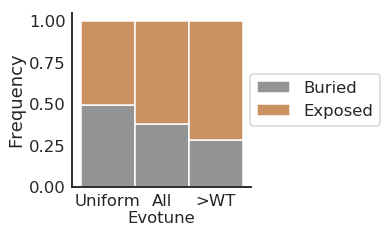

In [68]:
# First do the buried/ exposed 
first_layer = [expectation_buried, all_ET_buried_freq, bright_buried_freq]
second_layer = [expectation_exposed, all_ET_exposed_freq, bright_exposed_freq]
fig, ax = plot_style_utils.simple_ax(figsize=(3.2,3.2))
ax.bar(np.arange(3),first_layer, color=palette[7], label="Buried", width=1)
ax.bar(np.arange(3), second_layer, color=palette[5], bottom=first_layer, label="Exposed", width=1)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Uniform', 'All\nEvotune', '>WT'])
ax.set_ylabel('Frequency')

ax.legend(loc="center left", bbox_to_anchor=(.95, 0.5))

plot_style_utils.save_for_pub(fig,'./blac_buried_exposed_bar.pdf')

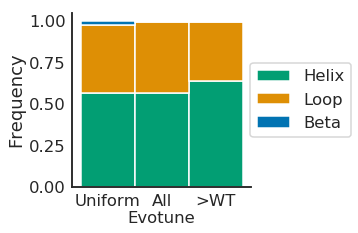

In [69]:
# Now secondary structure
first_layer = np.array([expectation['H'], all_mutants['H'], bright_mutants['H']])
second_layer = np.array([expectation['L'], all_mutants['L'], bright_mutants['L']])
third_layer = np.array([expectation['B'], all_mutants['B'], bright_mutants['B']])
#fourth_layer = np.array([expectation['X'], all_mutants['X'], bright_mutants['X']])
fig, ax = plot_style_utils.simple_ax(figsize=(3.2,3.2))
ax.bar(np.arange(3),first_layer, color=palette[2], label="Helix", width=1)
ax.bar(np.arange(3), second_layer, color=palette[1], bottom=first_layer, label="Loop", width=1)
ax.bar(np.arange(3), third_layer, color=palette[0],bottom=first_layer+second_layer, label="Beta", width=1)
#ax.bar(np.arange(3), fourth_layer, color=palette[3], bottom=first_layer+second_layer+third_layer, label="Chromophore", width=1)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Uniform', 'All\nEvotune', '>WT'])
ax.set_ylabel('Frequency')
ax.legend(loc="center left", bbox_to_anchor=(.95, 0.5))

plot_style_utils.save_for_pub(fig,'./blac_ss.pdf')

In [70]:
df_blac

,lfe_250,lfe_1000,lfe_2500,seq,model,ntrain,rep,special_case,qfunc,normalized_qfunc,region
21,-1.363510,-2.115004,-2.106211,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.115004,-2.115004,NNLLLTFIGGPVGLTVFIHNMGDHVTRLGRWEPELNEAIPNDERDT...
42,-1.256824,-1.364502,-2.451823,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,1,,-1.364502,-1.364502,TNLLLTMIGGPKELTAFLMNMGDLVTRLDRWEPELHEAIPNDERST...
43,-1.560870,-2.219854,-2.566812,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.219854,-2.219854,TNLLLTAIGGPCELAAFLHNMGDHVSRLFQWEPELNEAIPNDERDT...
52,-1.278590,-2.167248,-2.690297,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.167248,-2.167248,RNLLLTTMGGPQELTAFLHNMGDHPTRLDRWECELNEAIPNDERDT...
54,-1.480060,-1.896006,-2.215033,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-1.896006,-1.896006,RNLLLTFIGGPDELTAFLHNMGDHVTRLDRWEDELNEAIPNDERDT...
61,0.972426,0.866153,-0.996826,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,0.866153,0.866153,SNLILTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDT...
62,-1.529423,-2.671468,-2.416366,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,0,,-2.671468,-2.671468,SNLLITTIGGPHELTAFVHNMGDHVTRLDRWEPELNEAIPNDERDT...
65,-1.413604,-1.977831,-2.673369,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-1.977831,-1.977831,SNLLLTNIGGPKELTMFLHNMGDSVWRLDQWEPELNEAIPNDERDT...
66,-1.265810,-1.993909,-2.345103,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,2,,-1.993909,-1.993909,SNLLLTTIGGPKNLTAFLHNMGDHVTRLDRWEPKLNEAIPNDERDT...
67,-1.353576,-2.117295,-2.640344,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,1,,-2.117295,-2.117295,SNLLLTTIGGPKESTAFLHNMGDPVHRLDRWEPELTEAIPNDAFDT...


In [71]:
blac_struct

,aa,ss,rel_ASA,ASA,coord,d_from_active,buried,simple_ss
dssp_index,,,,,,,,
110,A,H,0.000000,0.0,[ 6.236 3.299 44.417],8.628804,True,H
111,N,H,0.146497,23.0,[ 8.664 2.224 47.099],10.973227,True,H
112,L,H,0.115854,19.0,[ 5.899 1.968 49.718],13.895819,True,H
113,L,H,0.000000,0.0,[ 3.728 -0.116 47.475],13.606889,True,H
114,L,H,0.000000,0.0,[ 6.66 -2.32 46.542],13.327358,True,H
115,T,H,0.640845,91.0,[ 7.091 -2.968 50.243],16.468018,False,H
116,T,H,0.190141,27.0,[ 3.459 -3.963 50.562],18.141924,True,H
117,I,H,0.118343,20.0,[ 3.73 -6.661 47.929],18.084209,True,H
118,G,T,0.523810,44.0,[ 7.048 -8.078 48.932],19.072718,False,L


In [72]:
blac_struct.index.value_counts()

127    1
167    1
149    1
150    1
151    1
152    1
153    1
154    1
155    1
156    1
157    1
158    1
159    1
160    1
161    1
162    1
163    1
164    1
165    1
148    1
147    1
146    1
136    1
129    1
130    1
131    1
132    1
133    1
134    1
135    1
      ..
117    1
118    1
119    1
120    1
121    1
122    1
123    1
124    1
125    1
189    1
188    1
187    1
177    1
170    1
171    1
172    1
173    1
174    1
175    1
176    1
178    1
186    1
179    1
180    1
181    1
182    1
183    1
184    1
185    1
128    1
Name: dssp_index, Length: 81, dtype: int64

In [73]:
blac_struct = blac_struct.reset_index(drop=False)
blac_struct

,dssp_index,aa,ss,rel_ASA,ASA,coord,d_from_active,buried,simple_ss
0,110,A,H,0.000000,0.0,[ 6.236 3.299 44.417],8.628804,True,H
1,111,N,H,0.146497,23.0,[ 8.664 2.224 47.099],10.973227,True,H
2,112,L,H,0.115854,19.0,[ 5.899 1.968 49.718],13.895819,True,H
3,113,L,H,0.000000,0.0,[ 3.728 -0.116 47.475],13.606889,True,H
4,114,L,H,0.000000,0.0,[ 6.66 -2.32 46.542],13.327358,True,H
5,115,T,H,0.640845,91.0,[ 7.091 -2.968 50.243],16.468018,False,H
6,116,T,H,0.190141,27.0,[ 3.459 -3.963 50.562],18.141924,True,H
7,117,I,H,0.118343,20.0,[ 3.73 -6.661 47.929],18.084209,True,H
8,118,G,T,0.523810,44.0,[ 7.048 -8.078 48.932],19.072718,False,L
9,119,G,S,0.059524,5.0,[ 9.683 -6.171 46.935],16.212597,True,L


In [74]:
def get_distances(seq):
    distances = []
    for i, aa in enumerate(seq):
        if blac_struct.aa[i] != aa:
            distances.append(blac_struct.d_from_active[i])
        # else it is not a mutation
    return distances

In [75]:
df_blac['d_from_active'] = df_blac.region.map(get_distances)
df_blac

/media/sandias42/ExDrive/Software/Python/Anaconda/envs/shared_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,lfe_250,lfe_1000,lfe_2500,seq,model,ntrain,rep,special_case,qfunc,normalized_qfunc,region,d_from_active
21,-1.363510,-2.115004,-2.106211,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.115004,-2.115004,NNLLLTFIGGPVGLTVFIHNMGDHVTRLGRWEPELNEAIPNDERDT...,"[8.628804206848145, 18.141923904418945, 18.090..."
42,-1.256824,-1.364502,-2.451823,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,1,,-1.364502,-1.364502,TNLLLTMIGGPKELTAFLMNMGDLVTRLDRWEPELHEAIPNDERST...,"[8.628804206848145, 18.141923904418945, 21.409..."
43,-1.560870,-2.219854,-2.566812,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.219854,-2.219854,TNLLLTAIGGPCELAAFLHNMGDHVSRLFQWEPELNEAIPNDERDT...,"[8.628804206848145, 18.141923904418945, 18.090..."
52,-1.278590,-2.167248,-2.690297,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.167248,-2.167248,RNLLLTTMGGPQELTAFLHNMGDHPTRLDRWECELNEAIPNDERDT...,"[8.628804206848145, 18.084209442138672, 18.090..."
54,-1.480060,-1.896006,-2.215033,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-1.896006,-1.896006,RNLLLTFIGGPDELTAFLHNMGDHVTRLDRWEDELNEAIPNDERDT...,"[8.628804206848145, 18.141923904418945, 18.090..."
61,0.972426,0.866153,-0.996826,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,0.866153,0.866153,SNLILTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDT...,"[8.628804206848145, 13.606888771057127, 19.673..."
62,-1.529423,-2.671468,-2.416366,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,0,,-2.671468,-2.671468,SNLLITTIGGPHELTAFVHNMGDHVTRLDRWEPELNEAIPNDERDT...,"[8.628804206848145, 13.32735824584961, 18.0900..."
65,-1.413604,-1.977831,-2.673369,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-1.977831,-1.977831,SNLLLTNIGGPKELTMFLHNMGDSVWRLDQWEPELNEAIPNDERDT...,"[8.628804206848145, 18.141923904418945, 20.385..."
66,-1.265810,-1.993909,-2.345103,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,2,,-1.993909,-1.993909,SNLLLTTIGGPKNLTAFLHNMGDHVTRLDRWEPKLNEAIPNDERDT...,"[8.628804206848145, 18.706287384033203, 10.921..."
67,-1.353576,-2.117295,-2.640344,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,1,,-2.117295,-2.117295,SNLLLTTIGGPKESTAFLHNMGDPVHRLDRWEPELTEAIPNDAFDT...,"[8.628804206848145, 15.648715019226074, 21.731..."


In [76]:
df_blac['repeat_qfunc'] = [
    [df_blac.normalized_qfunc[i]]*len(df_blac.d_from_active[i]) for i in df_blac.index.values
]
df_blac

/media/sandias42/ExDrive/Software/Python/Anaconda/envs/shared_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,lfe_250,lfe_1000,lfe_2500,seq,model,ntrain,rep,special_case,qfunc,normalized_qfunc,region,d_from_active,repeat_qfunc
21,-1.363510,-2.115004,-2.106211,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.115004,-2.115004,NNLLLTFIGGPVGLTVFIHNMGDHVTRLGRWEPELNEAIPNDERDT...,"[8.628804206848145, 18.141923904418945, 18.090...","[-2.1150039190664462, -2.1150039190664462, -2...."
42,-1.256824,-1.364502,-2.451823,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,1,,-1.364502,-1.364502,TNLLLTMIGGPKELTAFLMNMGDLVTRLDRWEPELHEAIPNDERST...,"[8.628804206848145, 18.141923904418945, 21.409...","[-1.3645016454608123, -1.3645016454608123, -1...."
43,-1.560870,-2.219854,-2.566812,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.219854,-2.219854,TNLLLTAIGGPCELAAFLHNMGDHVSRLFQWEPELNEAIPNDERDT...,"[8.628804206848145, 18.141923904418945, 18.090...","[-2.219854040421544, -2.219854040421544, -2.21..."
52,-1.278590,-2.167248,-2.690297,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-2.167248,-2.167248,RNLLLTTMGGPQELTAFLHNMGDHPTRLDRWECELNEAIPNDERDT...,"[8.628804206848145, 18.084209442138672, 18.090...","[-2.1672475678987144, -2.1672475678987144, -2...."
54,-1.480060,-1.896006,-2.215033,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-1.896006,-1.896006,RNLLLTFIGGPDELTAFLHNMGDHVTRLDRWEDELNEAIPNDERDT...,"[8.628804206848145, 18.141923904418945, 18.090...","[-1.8960059940473688, -1.8960059940473688, -1...."
61,0.972426,0.866153,-0.996826,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,0.866153,0.866153,SNLILTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDT...,"[8.628804206848145, 13.606888771057127, 19.673...","[0.8661528110672019, 0.8661528110672019, 0.866..."
62,-1.529423,-2.671468,-2.416366,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,0,,-2.671468,-2.671468,SNLLITTIGGPHELTAFVHNMGDHVTRLDRWEPELNEAIPNDERDT...,"[8.628804206848145, 13.32735824584961, 18.0900...","[-2.67146810592023, -2.67146810592023, -2.6714..."
65,-1.413604,-1.977831,-2.673369,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,0,,-1.977831,-1.977831,SNLLLTNIGGPKELTMFLHNMGDSVWRLDQWEPELNEAIPNDERDT...,"[8.628804206848145, 18.141923904418945, 20.385...","[-1.9778307260411336, -1.9778307260411336, -1...."
66,-1.265810,-1.993909,-2.345103,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,2,,-1.993909,-1.993909,SNLLLTTIGGPKNLTAFLHNMGDHVTRLDRWEPKLNEAIPNDERDT...,"[8.628804206848145, 18.706287384033203, 10.921...","[-1.9939085215399048, -1.9939085215399048, -1...."
67,-1.353576,-2.117295,-2.640344,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,1,,-2.117295,-2.117295,SNLLLTTIGGPKESTAFLHNMGDPVHRLDRWEPELTEAIPNDAFDT...,"[8.628804206848145, 15.648715019226074, 21.731...","[-2.1172949053884524, -2.1172949053884524, -2...."


In [77]:
all_qfunc = np.concatenate(df_blac.repeat_qfunc.values)
all_d = np.concatenate(df_blac.d_from_active.values)

In [78]:
all_qfunc

array([-2.11500392, -2.11500392, -2.11500392, ..., -1.87988545,
       -1.87988545, -1.87988545])

In [79]:
all_d

array([ 8.62880421, 18.1419239 , 18.09002876, ..., 18.97731018,
       19.89614296, 26.73031235])

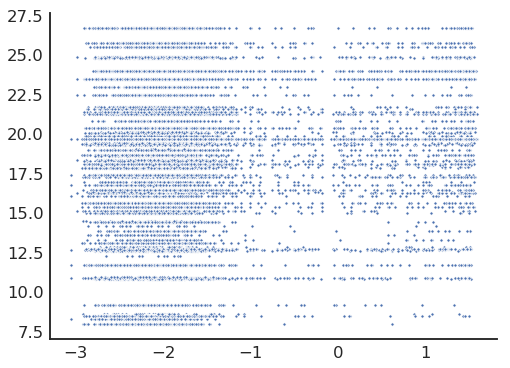

In [80]:
fig, ax = plot_style_utils.simple_ax(figsize=(8,6))

sns.scatterplot(x=all_qfunc, y=all_d,s=10, ax=ax)

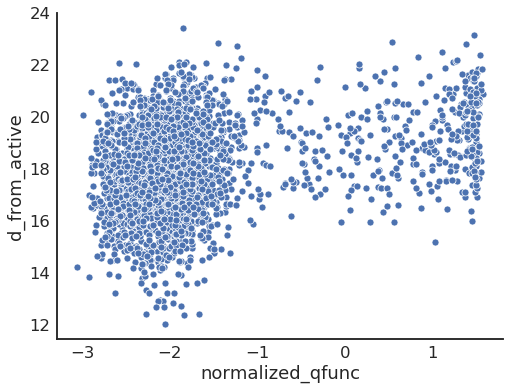

In [81]:
fig, ax = plot_style_utils.simple_ax(figsize=(8,6))

sns.scatterplot(x=df_blac.normalized_qfunc, y=df_blac.d_from_active.map(np.mean),s=50, ax=ax)

In [82]:
np.mean(blac_struct.d_from_active)

17.202163713949698

In [83]:
bright_df_blac = df_blac[df_blac.qfunc >= WT_FUNCTION]
bright_df_blac

,lfe_250,lfe_1000,lfe_2500,seq,model,ntrain,rep,special_case,qfunc,normalized_qfunc,region,d_from_active,repeat_qfunc
61,0.972426,0.866153,-0.996826,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,0.866153,0.866153,SNLILTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDT...,"[8.628804206848145, 13.606888771057127, 19.673...","[0.8661528110672019, 0.8661528110672019, 0.866..."
74,0.865278,1.374012,-1.066368,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,1.374012,1.374012,SNLLLTTIGGPKELTAFLYNMGDHVTRLDRWEPELNEAMPNDERDT...,"[8.628804206848145, 21.409963607788086, 16.281...","[1.3740123280429777, 1.3740123280429777, 1.374..."
83,0.923991,1.075832,-1.213811,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,1.075832,1.075832,SNLLLTTVGGPKELTAFLHNMGDHVTRIDRWEPELNEAIPNDERDT...,"[8.628804206848145, 18.084209442138672, 12.756...","[1.0758317268892732, 1.0758317268892732, 1.075..."
378,0.926344,1.141497,-1.182145,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,3,,1.141497,1.141497,ANILLTTIGGPKELTAFLHNMGDKITRLDRWEPELNEAIPNDERDT...,"[13.895818710327148, 21.731351852416992, 19.30...","[1.1414970978076355, 1.1414970978076355, 1.141..."
380,0.897095,1.509842,1.516078,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,1.509842,1.509842,ANILLTTIGGPKELTAFLHNMGDTVTRLDRWEPELNEAIPNDERDT...,"[13.895818710327148, 21.731351852416992, 19.67...","[1.509842123349319, 1.509842123349319, 1.50984..."
381,0.903322,1.507083,1.032197,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,1.507083,1.507083,ANILLTTIGGPKELTAFLHNMGDHITRLDRWEPELNQAIPNDERDS...,"[13.895818710327148, 19.302413940429688, 11.72...","[1.507083392349295, 1.507083392349295, 1.50708..."
393,0.963413,1.040076,-1.413288,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,1.040076,1.040076,ANILLTTIGGPKELAGFLHAMGDHVTRLDRWEPELNEAIPNDERDT...,"[13.895818710327148, 16.963493347167972, 20.38...","[1.0400762547355882, 1.0400762547355882, 1.040..."
394,0.962640,1.263997,-1.134769,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,24,3,,1.263997,1.263997,ANILLTTIGGPKEVTAFIHNMGDHVTRLDRWEPELNEAIPNDERDT...,"[13.895818710327148, 15.648715019226074, 18.30...","[1.2639970237775875, 1.2639970237775875, 1.263..."
408,0.954541,-0.024209,-1.270702,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,-0.024209,-0.024209,ANILLTTIGGPRELTIFLHNMGDHVTRLDRWEPEVNEAIPNDERDT...,"[13.895818710327148, 18.090028762817386, 20.38...","[-0.024208826383206983, -0.024208826383206983,..."
411,0.953524,1.505887,-0.948183,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,ET_Global_Init_1,96,3,,1.505887,1.505887,ANILLTTIGGPAELTSFLHQMGDHVTRLDRWEPELNEAIPNDERDT...,"[13.895818710327148, 18.090028762817386, 20.38...","[1.505887472186794, 1.505887472186794, 1.50588..."


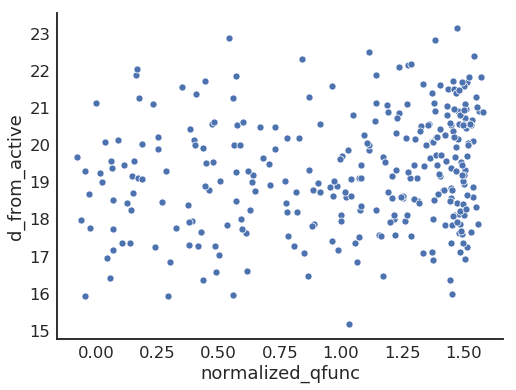

In [84]:
fig, ax = plot_style_utils.simple_ax(figsize=(8,6))

sns.scatterplot(x=bright_df_blac.normalized_qfunc, y=bright_df_blac.d_from_active.map(np.mean),s=50, ax=ax)

In [85]:
all_qfunc = np.concatenate(bright_df_blac.repeat_qfunc.values)
all_d = np.concatenate(bright_df_blac.d_from_active.values)

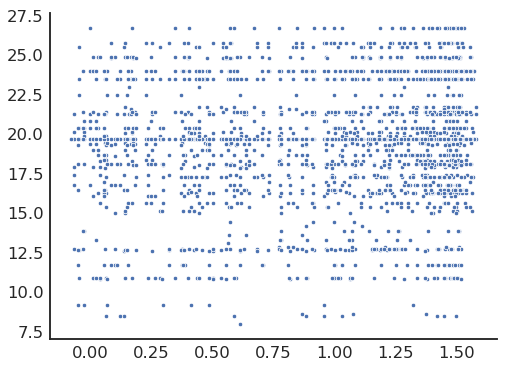

In [86]:
fig, ax = plot_style_utils.simple_ax(figsize=(8,6))

sns.scatterplot(x=all_qfunc, y=all_d,s=20, ax=ax)

0.0006745811836931259


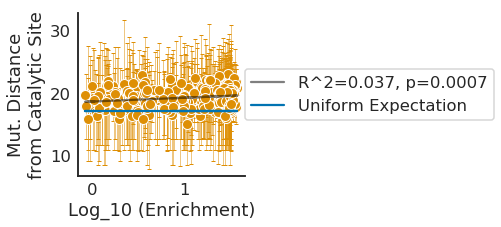

In [87]:
fig, ax = plot_style_utils.simple_ax(figsize=(3,3))
p10 = lambda x: np.percentile(x,.1)
p90 = lambda x: np.percentile(x,.9)
maxmin = np.array([bright_df_blac.d_from_active.map(p10), bright_df_blac.d_from_active.map(p90)])
maxmin = np.abs(maxmin - bright_df_blac.d_from_active.map(np.mean).values.T)
x = bright_df_blac.normalized_qfunc.values
y = bright_df_blac.d_from_active.map(np.mean).values
ax.errorbar(x,
            y, 
            maxmin, 
            linestyle='None',marker='o', linewidth=.5, markersize=10,markeredgecolor='white', 
            capsize=2, color=palette[1], markeredgewidth=1, alpha=1)

slope, intercept, r_value, p_value, std_err = scistats.linregress(x, y)
print(p_value)
ax.plot(x, intercept + slope*x, color='black', alpha=.5, 
        label=f'R^2={np.around(r_value ** 2, 3)}, p={np.around(p_value,4)}', zorder=10000)
ax.plot(x, [np.mean(blac_struct.d_from_active)] * len(x),color=palette[0], alpha=1, 
        label=f'Uniform Expectation', zorder=1000) 
ax.legend(loc="center left", bbox_to_anchor=(.95, 0.5))
ax.set_xlabel('Log_10 (Enrichment)')
ax.set_ylabel('Mut. Distance\nfrom Catalytic Site')
plot_style_utils.save_for_pub(fig,'./blac_distance_correlation.pdf')

In [88]:

num_bright_mutants / np.sum(num_bright_mutants)

array([0.00169014, 0.        , 0.00788732, 0.00169014, 0.0056338 ,
       0.01859155, 0.01295775, 0.01295775, 0.        , 0.        ,
       0.        , 0.03605634, 0.02929577, 0.01633803, 0.00450704,
       0.03549296, 0.01070423, 0.01295775, 0.01070423, 0.04394366,
       0.01239437, 0.00112676, 0.        , 0.01633803, 0.01464789,
       0.00169014, 0.00450704, 0.01408451, 0.00225352, 0.01408451,
       0.0056338 , 0.        , 0.0056338 , 0.02985915, 0.00450704,
       0.00056338, 0.02253521, 0.00507042, 0.02873239, 0.00169014,
       0.00901408, 0.00056338, 0.01239437, 0.00056338, 0.        ,
       0.00394366, 0.00112676, 0.02422535, 0.        , 0.03549296,
       0.00732394, 0.00619718, 0.00169014, 0.01746479, 0.00394366,
       0.00957746, 0.01183099, 0.03380282, 0.01577465, 0.00901408,
       0.02140845, 0.01690141, 0.01802817, 0.07323944, 0.00225352,
       0.01859155, 0.02704225, 0.02816901, 0.00338028, 0.01352113,
       0.02704225, 0.01746479, 0.00338028, 0.03042254, 0.00901

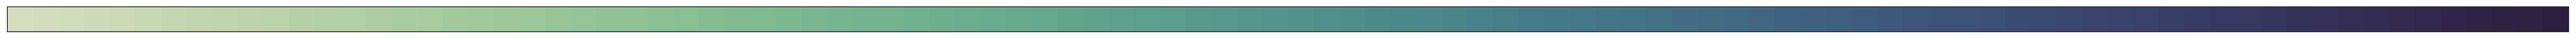

In [89]:
sns.palplot(plot_style_utils.SEQ_PALETTE)

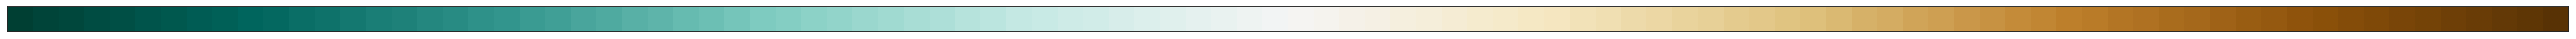

In [90]:
sns.palplot(plot_style_utils.DIV_PALETTE)

In [91]:
from matplotlib.colors import ListedColormap


In [92]:
import matplotlib.colors as colors

In [93]:
to_color = num_bright_mutants / np.sum(num_bright_mutants)
print(np.sum(to_color))
to_color = to_color / np.max(to_color)

0.9999999999999999


In [94]:
def prop_vals_to_idx(x):
    return np.round(255*(x - np.min(x))/(np.max(x) - np.min(x))).astype(int)
def prop_vals_to_rgb(x, cmap):
    return cmap(prop_vals_to_idx(x)).squeeze()[:,:3]
def rgb_to_hex(rgb):
    return ["0x{0:02x}{1:02x}{2:02x}".format(
        int(np.round(255*rgb[i,0])), 
        int(np.round(255*rgb[i,1])), 
        int(np.round(255*rgb[i,2]))) for i in range(rgb.shape[0])]
def prop_vals_to_hex(x, cmap):
    return rgb_to_hex(prop_vals_to_rgb(x, cmap))

In [95]:

cmap =cm.get_cmap(name='GnBu')
print(prop_vals_to_hex(to_color,cmap))

['0xf3faec', '0xf7fcf0', '0xe4f4de', '0xf3faec', '0xe9f6e3', '0xcbeac4', '0xd8f0d2', '0xd8f0d2', '0xf7fcf0', '0xf7fcf0', '0xf7fcf0', '0x7dcdc3', '0x9fdab8', '0xd0edca', '0xebf7e5', '0x80cec2', '0xddf2d7', '0xd8f0d2', '0xddf2d7', '0x57b8d0', '0xd9f0d3', '0xf4fbed', '0xf7fcf0', '0xd0edca', '0xd4eece', '0xf3faec', '0xebf7e5', '0xd5efcf', '0xf1faeb', '0xd5efcf', '0xe9f6e3', '0xf7fcf0', '0xe9f6e3', '0x9cd9b9', '0xebf7e5', '0xf6fbef', '0xbce5be', '0xeaf7e4', '0xa2dbb7', '0xf3faec', '0xe1f3dc', '0xf6fbef', '0xd9f0d3', '0xf6fbef', '0xf7fcf0', '0xedf8e7', '0xf4fbed', '0xb5e2bb', '0xf7fcf0', '0x80cec2', '0xe4f5df', '0xe7f6e2', '0xf3faec', '0xceecc7', '0xedf8e7', '0xdff3da', '0xdaf1d5', '0x88d1c0', '0xd1edcb', '0xe1f3dc', '0xbfe6bf', '0xcfecc8', '0xccebc6', '0x084081', '0xf1faeb', '0xcbeac4', '0xaadeb6', '0xa5dcb6', '0xeef9e8', '0xd7efd1', '0xaadeb6', '0xceecc7', '0xeef9e8', '0x99d7ba', '0xe1f3dc', '0xf7fcf0', '0xf6fbef', '0xddf2d7', '0xd7efd1', '0xf7fcf0', '0xd4eece']


In [96]:
to_color

array([0.02307692, 0.        , 0.10769231, 0.02307692, 0.07692308,
       0.25384615, 0.17692308, 0.17692308, 0.        , 0.        ,
       0.        , 0.49230769, 0.4       , 0.22307692, 0.06153846,
       0.48461538, 0.14615385, 0.17692308, 0.14615385, 0.6       ,
       0.16923077, 0.01538462, 0.        , 0.22307692, 0.2       ,
       0.02307692, 0.06153846, 0.19230769, 0.03076923, 0.19230769,
       0.07692308, 0.        , 0.07692308, 0.40769231, 0.06153846,
       0.00769231, 0.30769231, 0.06923077, 0.39230769, 0.02307692,
       0.12307692, 0.00769231, 0.16923077, 0.00769231, 0.        ,
       0.05384615, 0.01538462, 0.33076923, 0.        , 0.48461538,
       0.1       , 0.08461538, 0.02307692, 0.23846154, 0.05384615,
       0.13076923, 0.16153846, 0.46153846, 0.21538462, 0.12307692,
       0.29230769, 0.23076923, 0.24615385, 1.        , 0.03076923,
       0.25384615, 0.36923077, 0.38461538, 0.04615385, 0.18461538,
       0.36923077, 0.23846154, 0.04615385, 0.41538462, 0.12307

In [97]:
ticks = np.linspace(0, 
                               np.max(num_bright_mutants / np.sum(num_bright_mutants)),
                               num=6
                              )
ticks = np.around(ticks,2)
ticks

array([0.  , 0.01, 0.03, 0.04, 0.06, 0.07])

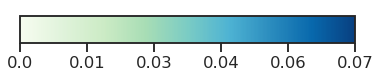

In [98]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=None,
                                orientation='horizontal')

cb1.ax.set_xticklabels(ticks)
plot_style_utils.save_for_pub(fig,'./blac_colorbar.pdf')